# REGULARIZED LINEAR MODELS

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
import math
%config InlineBackend.figure_format = 'svg' #set 'png' here when working on notebook
%matplotlib inline

In [30]:
from azureml import Workspace
ws = Workspace(
    workspace_id='556d475f8b30495db749adc7d9379947',
    authorization_token='5a9f262ff3ab4807801d0dcad7c68e4c',
    endpoint='https://studioapi.azureml.net'
)
ds = ws.datasets['hour.csv']
hour = ds.to_dataframe()

In [31]:
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1


In [32]:
hour.drop(["instant","dteday"],axis=1,inplace=True)

In [33]:
X = hour.drop("cnt",axis=1)
y = hour.cnt

## PRE-PROCESSING

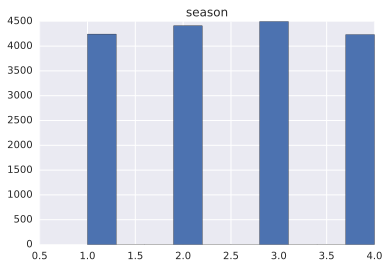

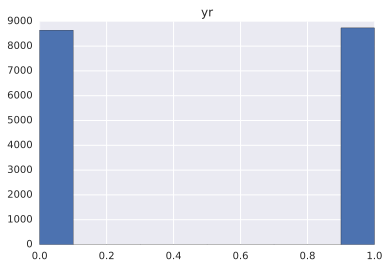

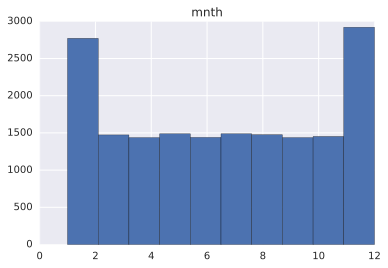

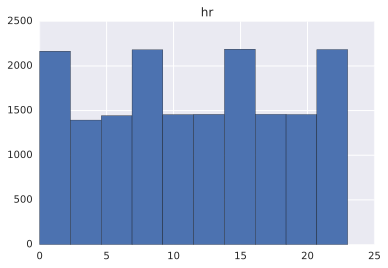

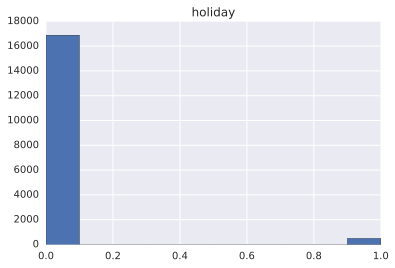

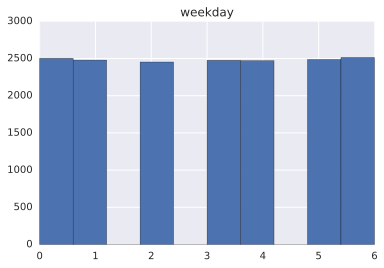

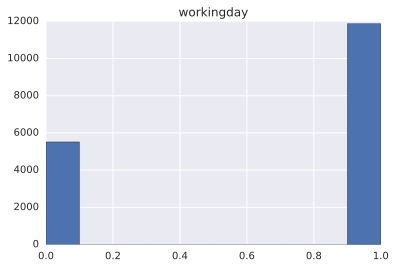

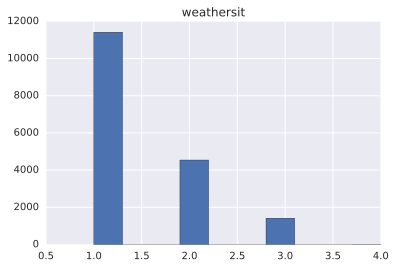

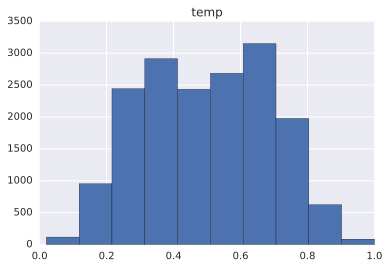

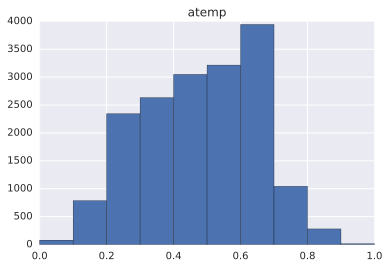

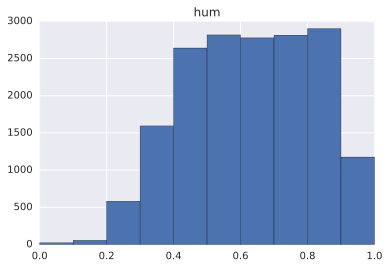

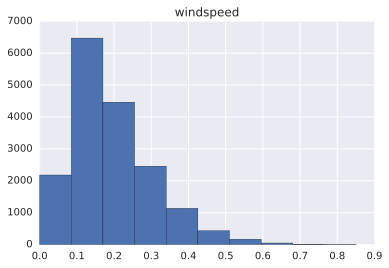

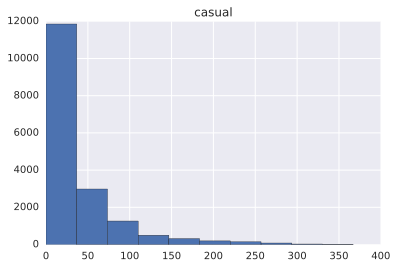

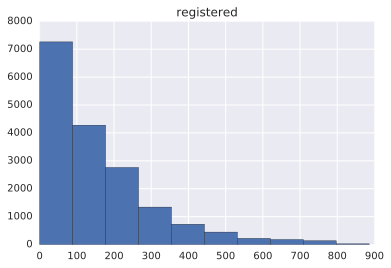

In [34]:
for col in X.columns:
    plt.hist(X[col])
    plt.title(col)
    plt.show()

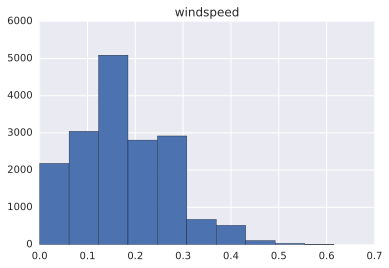

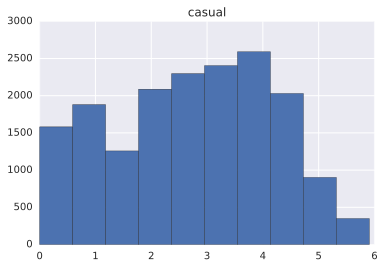

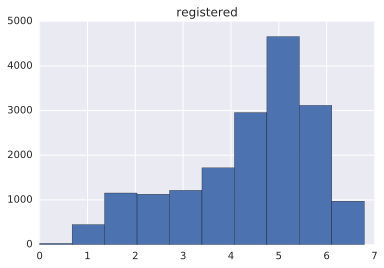

In [35]:
skewed_feats = ["windspeed", "casual", "registered"]
for col in skewed_feats:
    plt.hist(X[col].map(lambda x: math.log(x + 1)))
    plt.title(col)
    plt.show()

In [36]:
for col in skewed_feats:
    X[col] = X[col].map(lambda x: math.log(x + 1))

## MODELS

### Ridge and Lasso Regression

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [37]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="mean_squared_error", cv = 5))
    return(rmse)

In [38]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [39]:
alphas = range(100, 10000, 100)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

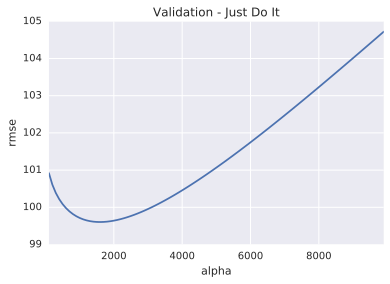

In [40]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [41]:
cv_ridge.index[cv_ridge == cv_ridge.min()]

Int64Index([1600], dtype='int64')

In [42]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)

/home/nbuser/env3/lib/python3.4/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


In [43]:
rmse_cv(model_lasso).mean()

/home/nbuser/env3/lib/python3.4/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/nbuser/env3/lib/python3.4/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/nbuser/env3/lib/python3.4/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/nbuser/env3/lib/python3.4/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':
/home/nbuser/env3/lib/python3.4/site-packages/sklearn/linear_model/b

101.13409764023143

Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [44]:
coef = pd.Series(model_lasso.coef_, index = X.columns)

In [45]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 5 variables


In [46]:
preds = pd.DataFrame({"preds":model_lasso.predict(X), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]

### RANdom SAmple Consensus (RANSAC) and Elastic Net

RANSAC fits a regression model to a subset of the data, the so-called inliers. Hence, this regression technique is less sensitive to outliers. Elastic Net is a combination of Ridge and Lasso.

In [47]:
from sklearn.linear_model import LinearRegression, RANSACRegressor

In [48]:
ransac = RANSACRegressor(LinearRegression(),max_trials=100, min_samples=70,
                         residual_metric=lambda x: np.sum(np.abs(x), axis=1),
                         residual_threshold=2.0, random_state=1301)

In [49]:
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, max_trials=100,
        min_samples=70, random_state=1301,
        residual_metric=<function <lambda> at 0x7f9eb00e0510>,
        residual_threshold=2.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [50]:
ransac.predict(X)[:,0]

array([  49.48458682,  123.44396056,  101.68341378, ...,   47.17210766,
         21.91861759,    7.42814751])

In [52]:
rmse = np.sqrt(np.mean((preds['true']-preds['preds'])**2))
print ('RMSE: {0:.4f}'.format(rmse))

RMSE: 111.6705


In [53]:
from sklearn.metrics import r2_score

In [54]:
print('R^2 train: %.3f' %  r2_score(preds['true'], preds['preds']))

R^2 train: 0.621


In [55]:
coef = pd.Series(ransac.estimator_.coef_[0,:], index = X.columns)

In [70]:
from sklearn.linear_model import ElasticNet

In [71]:
elastic = ElasticNet(alpha=10.0, l1_ratio=0.005)

In [72]:
elastic.fit(X, y)

ElasticNet(alpha=10.0, copy_X=True, fit_intercept=True, l1_ratio=0.005,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [73]:
rmse = np.sqrt(np.mean((preds['true']-preds['preds'])**2))
print ('RMSE: {0:.4f}'.format(rmse))

RMSE: 111.6705


In [74]:
print('R^2 train: %.3f' %  r2_score(preds['true'], preds['preds']))

R^2 train: 0.621


In [75]:
from itertools import product

In [77]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
l1_ratios = [1, 0.1, 0.001, 0.0005]

In [80]:
from sklearn.cross_validation import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="mean_squared_error", cv = 5))
    return(rmse)

In [81]:
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio)).mean() 
            for (alpha, l1_ratio) in product(alphas, l1_ratios)]

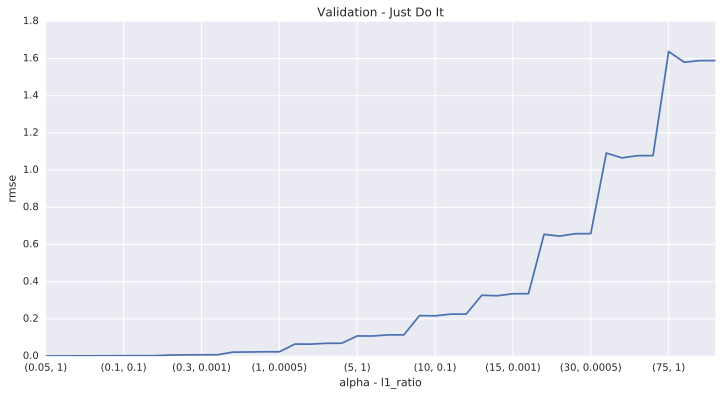

In [82]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Validation - Just Do It")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")